<a href="https://colab.research.google.com/github/pcpiscator/2T2021/blob/main/C%C3%B3pia_de_Furg_ECD_Machine_Learning_II_Semana_09_Processamento_de_linguagem_natural_com_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Especialização em Ciência de Dados - FURG
## Machine Learning II - Processamento de linguagem natural com RNNs
### Prof. Marcelo Malheiros

Parte do código adaptada de Aurélien Geron (licença Apache-2.0)

---

# Inicialização

Aqui importamos as bibliotecas fundamentais de Python para este _notebook_:

- NumPy: suporte a vetores, matrizes e operações de Álgebra Linear
- Matplotlib: biblioteca de visualização de dados
- Scikit-Learn: biblioteca com algoritmos de Machine Learning

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn

Este _notebook_, em particular, utiliza a biblioteca Keras para definir e treinar redes neurais. Aqui utilizamos a versão **integrada** de Keras, que já vem como parte da biblioteca mais geral TensorFlow. Ambas já fazem parte do ambiente Colaboratory.

Para quem utiliza o ambiente Anaconda, é preciso primeiro instalar o pacote `tensorflow`. Isso pode ser feito com o seguinte comando:

    conda install tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras

print('tensorflow:      versão', tf.__version__)
print('keras integrada: versão', keras.__version__)

tensorflow:      versão 2.6.0
keras integrada: versão 2.6.0


Este _notebook_ também utiliza a biblioteca `pydot` e a ferramenta Graphviz para visualizar as redes neurais. Ambos já fazem parte do ambiente Colaboratory.

Para quem utiliza o ambiente Anaconda, é preciso primeiro instalar os pacotes `pydot` e `graphviz`. Isso pode ser feito com o seguinte comando:

    conda install pydot graphviz

In [3]:
import pydot

# Previsão de uma série temporal

Suponha que você esteja estudando o número de usuários ativos por hora em um site, ou a temperatura diária de uma cidade, ou a saúde financeira de uma empresa, medida trimestralmente usando várias métricas. Em todos esses casos, os dados serão uma sequência de um ou mais valores por intervalo de tempo. Isso é chamado de **série temporal**.

Nos primeiros dois exemplos, há um único valor por intervalo de tempo, então essas são **séries temporais univariadas**, enquanto no exemplo financeiro existem vários valores por intervalo de tempo (por exemplo, a receita da empresa, dívida, e assim por diante), por isso é uma **série temporal multivariada**.

Uma tarefa típica é prever valores futuros, o que é chamado de **previsão**. Outra tarefa comum é preencher espaços em branco, ou seja, completar valores ausentes do passado. Isso é chamado de **imputação**.

## Criação dos dados

Aqui vamos criar algumas séries temporais univariadas, com dados aleatórios. Cada uma terá 50 valores, que correspondem a 50 medidas ao longo do tempo.

A função a seguir cria tantas séries temporais quanto solicitadas (por meio do parâmetro `batch_size`), cada uma com comprimento `n_steps`, e há apenas um valor por intervalo de tempo em cada série (todas as séries são univariadas).

A função retorna portanto uma matriz NumPy na forma `[tamanho do lote, etapas de tempo, 1]`, onde cada série é a soma de duas ondas senoidais de amplitudes fixas, mas com frequências e fases aleatórias, além da adição de um pouco de ruído.

**Nota:** Ao lidar com séries temporais (e outros tipos de sequências, como visto posteriormente), os atributos de entrada são geralmente representados como matrizes 3D na forma `[tamanho do lote, etapas de tempo, dimensionalidade]`, onde dimensionalidade é 1 para séries temporais univariadas e ou maior para séries temporais multivariadas.

In [4]:
# função para criar séries temporais
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   onda 1
    series += 0.1 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + onda 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + ruído
    return series[..., np.newaxis].astype(np.float32)

In [6]:
# inicialização de semente dos valores aleatórios
np.random.seed(42)

# geração de 1000 séries univariadas, cada uma com 50 medidas ao longo do tempo + um valor a ser previsto
n_steps = 50
series = generate_time_series(1000, n_steps + 1)

Vamos separar estes dados em conjuntos de treino, validação e teste.

A matriz `X_treino` contém 700 séries temporais (ou seja, sua forma é `[700, 50, 1]`), enquanto `X_valid` contém 200 (da série temporal 700 até a 899) e `X_teste` contém 100 (da 900 até a 999).

Uma vez que queremos prever um único valor para cada série, os rótulos são vetores de coluna (por exemplo, `y_treino` tem formato `[700, 1]`).

In [7]:
# criação dos conjuntos
X_treino, y_treino = series[:700, :n_steps], series[:700, -1]
X_valid, y_valid = series[700:900, :n_steps], series[700:900, -1]
X_teste, y_teste = series[900:, :n_steps], series[900:, -1]

In [8]:
print('treino    atributos:', X_treino.shape)
print('treino    rótulos:  ', y_treino.shape)
print('validação atributos:', X_valid.shape)
print('validação rótulos:  ', y_valid.shape)
print('teste     atributos:', X_teste.shape)
print('teste     rótulos:  ', y_teste.shape)

treino    atributos: (700, 50, 1)
treino    rótulos:   (700, 1)
validação atributos: (200, 50, 1)
validação rótulos:   (200, 1)
teste     atributos: (100, 50, 1)
teste     rótulos:   (100, 1)


In [9]:
# função auxiliar para exibir uma série temporal
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'go')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'rx', markersize=10)
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

O objetivo é **prever** o valor final de cada série, indicado como um X vermelho. O valor real, omitido dos dados de entrada mas usado como valor real para efeito de validação, é mostrado como um ponto verde.

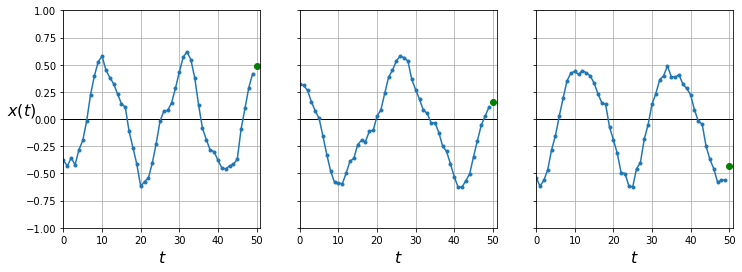

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=('$x(t)$' if col==0 else None))
plt.show()

## Comparativo: previsão ingênua

É importante fazer outras estimativas para o valor futuro como **baseline**, ou seja, como ponto de comparação para a qualidade de previsão.

A abordagem mais simples é prever o último valor de cada série simplesmente repetindo o penúltimo valor. Isso é chamado de **previsão ingênua** (_naive prediction_) e mesmo assim pode ser útil.

Calculamos então o erro através da função MSE entre o previsto e o real (para todas as séries), usando o conjunto de teste.

In [11]:
y_pred = X_teste[:, -1]
print('MSE:', np.mean(keras.losses.mean_squared_error(y_teste, y_pred)))

MSE: 0.017556487


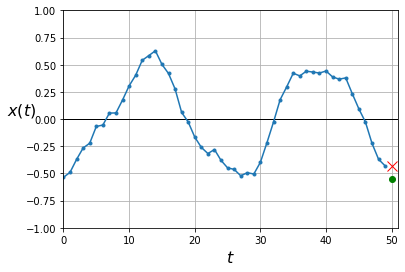

In [12]:
plot_series(X_teste[0, :, 0], y_teste[0, 0], y_pred[0, 0])
plt.show()

## Comparativo: rede neural densa

Outra abordagem simples é usar uma **rede neural densa**, ou seja uma rede neural com uma camada completamente conectada.

Como redes tradicionais esperam como entrada um conjunto simples de dados, precisamos adicionar no início uma camada do tipo `Flatten`.

O efeito de treinar uma rede com uma única camada do tipo `Dense` é equivalente a um ajuste linear de curvas, como em um modelo de regressão linear. De fato, cada previsão será apenas uma combinação linear dos valores de sua respectiva série temporal.

In [13]:
# comando para 'zerar' a biblioteca Keras
keras.backend.clear_session()

# definição de sementes aleatórias
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
# modelo
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

Vamos compilar este modelo usando a função MSE como medida de desempenho (perda ou _loss_). Também vamos usar o otimizador Adam padrão como estratégia de treinamento.

In [15]:
# compilação
model.compile(loss='mse', optimizer='adam')

# treinamento
%time history = model.fit(X_treino, y_treino, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
22/22 [==============================] - 1s 8ms/step - loss: 0.1658 - val_loss: 0.1382
Epoch 2/20
22/22 [==============================] - 0s 2ms/step - loss: 0.1172 - val_loss: 0.1041
Epoch 3/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0903 - val_loss: 0.0844
Epoch 4/20
22/22 [==============================] - 0s 3ms/step - loss: 0.0748 - val_loss: 0.0713
Epoch 5/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0622
Epoch 6/20
22/22 [==============================] - 0s 3ms/step - loss: 0.0556 - val_loss: 0.0540
Epoch 7/20
22/22 [==============================] - 0s 3ms/step - loss: 0.0486 - val_loss: 0.0477
Epoch 8/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0422
Epoch 9/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0376
Epoch 10/20
22/22 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0340
Epoch 11/20
22/22 [

In [17]:
# função auxiliar para exibição da curva de aprendizado
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='erro de treinamento')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='erro de validação')
    plt.axis([1, 20, 0, 0.1])
    plt.legend(fontsize=14)
    plt.xlabel('épocas')
    plt.ylabel('erro')
    plt.grid(True)
    plt.show()

Vamos exibir agora as curvas de aprendizado.

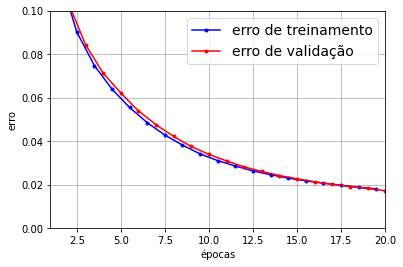

In [18]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

Agora podemos avaliar o modelo linear sobre o conjunto de teste.

In [19]:
print('MSE:', model.evaluate(X_teste, y_teste))

4/4 [==============================] - 0s 3ms/step - loss: 0.0183
MSE: 0.018333353102207184


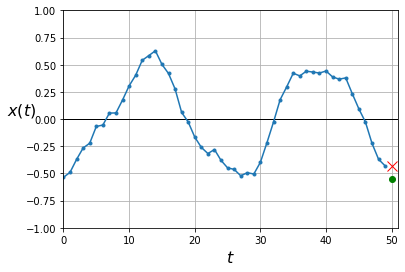

In [21]:
n_teste = 0
y_pred = model.predict(X_teste)
plot_series(X_teste[n_teste, :, 0], y_teste[n_teste, 0], y_pred[n_teste, 0])
plt.show()

## Criando uma RNN simples

Vamos construir a RNN mais simples possível, com uma única camada e com um único neurônio.

Lembrando, não precisamos especificar o comprimento das sequências de entrada (ao contrário do modelo anterior, tradicional), pois uma rede neural recorrente pode processar qualquer número de etapas de tempo. É por isso que definimos a primeira dimensão de entrada como `None`.

Por padrão, uma camada do tipo `SimpleRNN` usa como função de ativação a tangente hiperbólica.

Esta rede funciona assim: o estado inicial $h_{-1}$ é definido como 0 e passado para um único neurônio recorrente, junto com o valor da primeira etapa de tempo, $x_0$. O neurônio calcula uma soma ponderada desses valores e aplica a função de ativação tangente hiperbólica ao resultado, obtendo a primeira saída, $y_0$. Em um RNN simples, essa saída também é o novo estado $h_0$, que é passado para o mesmo neurônio recorrente junto com o próximo valor de entrada, $x_1$. Este processo é repetido até a última etapa de tempo. Em seguida, a camada recorrente produz como saída apenas o último valor $y_{49}$.

Este processo é realizado simultaneamente, e de forma transparente, para todas as demais séries temporais.

In [22]:
# comando para 'zerar' a biblioteca Keras
keras.backend.clear_session()

# definição de sementes aleatórias
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
# modelo
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=(None, 1))
])

In [24]:
# compilação
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)

# treinamento
%time history = model.fit(X_treino, y_treino, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
22/22 [==============================] - 1s 18ms/step - loss: 0.1949 - val_loss: 0.1118
Epoch 2/20
22/22 [==============================] - 0s 10ms/step - loss: 0.0792 - val_loss: 0.0702
Epoch 3/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0590 - val_loss: 0.0553
Epoch 4/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0484 - val_loss: 0.0472
Epoch 5/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0411 - val_loss: 0.0410
Epoch 6/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0361 - val_loss: 0.0368
Epoch 7/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0321 - val_loss: 0.0327
Epoch 8/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.0298
Epoch 9/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0267 - val_loss: 0.0276
Epoch 10/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0247 - val_loss: 0.0253
Epoch 11/20
22/22

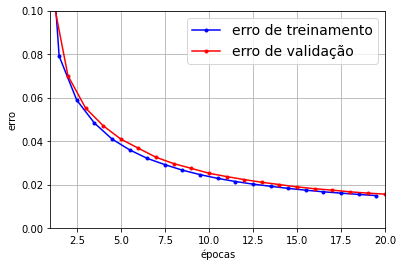

In [25]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [26]:
print('MSE:', model.evaluate(X_teste, y_teste))

4/4 [==============================] - 0s 6ms/step - loss: 0.0169
MSE: 0.016878601163625717


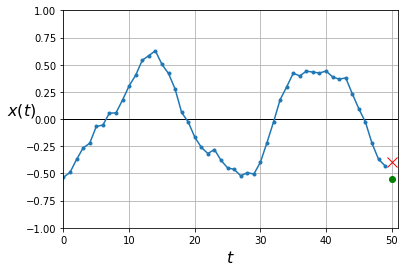

In [27]:
n_teste = 0
y_pred = model.predict(X_teste)
plot_series(X_teste[n_teste, :, 0], y_teste[n_teste, 0], y_pred[n_teste, 0])
plt.show()

## Criando uma RNN complexa

Implementar uma RNN mais complexa com Keras é simples: basta empilhar outras camadas recorrentes.

A seguir usaremos duas camadas `SimpleRNN`. Certifique-se de definir `return_sequences=True` para todas as camadas recorrentes (exceto a última, se você se preocupa apenas com a última saída). Do contrário, eles produzirão uma matriz 2D (contendo apenas a saída da última etapa de tempo) em vez de uma matriz 3D (contendo saídas para todas as etapas de tempo), e a próxima camada recorrente reclamará que você não a está alimentando sequências no formato 3D esperado.

Vamos também fazer com que a camada de saída seja `Dense`: ela permite escolher qualquer função de ativação de saída que desejarmos.

In [28]:
# comando para 'zerar' a biblioteca Keras
keras.backend.clear_session()

# definição de sementes aleatórias
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
# modelo
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [30]:
# compilação
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)

# treinamento
%time history = model.fit(X_treino, y_treino, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
22/22 [==============================] - 2s 31ms/step - loss: 0.0804 - val_loss: 0.0098
Epoch 2/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 3/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 4/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 5/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 6/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 7/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 8/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 9/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 10/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 11/

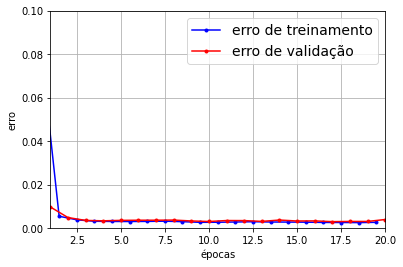

In [31]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [32]:
print('MSE:', model.evaluate(X_teste, y_teste))

4/4 [==============================] - 0s 6ms/step - loss: 0.0030
MSE: 0.0030241874046623707


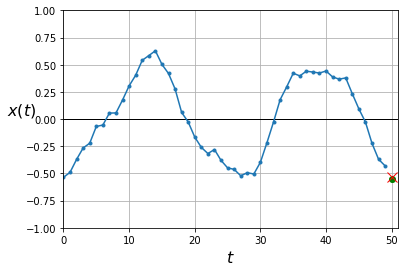

In [33]:
n_teste = 0
y_pred = model.predict(X_teste)
plot_series(X_teste[n_teste, :, 0], y_teste[n_teste, 0], y_pred[n_teste, 0])
plt.show()

In [34]:
# resumo legível da arquitetura deste modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


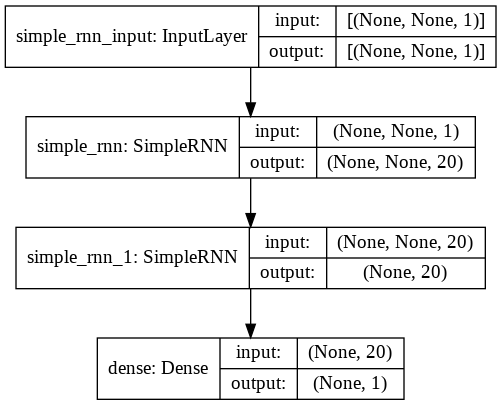

In [35]:
# figura da arquitetura deste modelo
keras.utils.plot_model(model, 'model.png', show_shapes=True)

# Previsão de vários valores futuros

Agora vamos criar modelos para prever os próximos 10 valores.

Primeiro, precisamos regenerar as séries temporais para incluir mais 9 etapas de tempo como rótulos.

In [36]:
# apagar os rótulos antigos (univariados) para evitar confusão
for v in ['y_treino', 'y_valid', 'y_teste', 'y_pred']:
    globals().pop(v, None)

In [37]:
# inicialização de semente dos valores aleatórios
np.random.seed(42)

# geração de 1000 séries univariadas, cada uma com 50 medidas ao longo do tempo + 10 valores a ser previstos
n_steps = 50
series = generate_time_series(1000, n_steps + 10)

# criação dos conjuntos
X_treino, Y_treino = series[:700, :n_steps], series[:700, -10:, 0]
X_valid, Y_valid = series[700:900, :n_steps], series[700:900, -10:, 0]
X_teste, Y_teste = series[900:, :n_steps], series[900:, -10:, 0]

In [38]:
print('treino    atributos:', X_treino.shape)
print('treino    rótulos:  ', Y_treino.shape)
print('validação atributos:', X_valid.shape)
print('validação rótulos:  ', Y_valid.shape)
print('teste     atributos:', X_teste.shape)
print('teste     rótulos:  ', Y_teste.shape)

treino    atributos: (700, 50, 1)
treino    rótulos:   (700, 10)
validação atributos: (200, 50, 1)
validação rótulos:   (200, 10)
teste     atributos: (100, 50, 1)
teste     rótulos:   (100, 10)


In [39]:
# função auxiliar para exibir uma série temporal, com múltiplas previsões
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[0]
    ahead = Y.shape[0]
    plot_series(X)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y, 'go-', label='real')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred, 'rx-', label='previsto', markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

## Comparativo: previsão ingênua

Agora nossa previsão ingênua é supor que o último valor se repete 10 vezes no futuro.

Como antes, vamos calcular o erro através da função MSE entre o previsto e o real (para todas as séries), usando o conjunto de teste.

In [40]:
# pegue o último valor e repita dez vezes
Y_pred = np.tile(X_teste[:, -1], 10)

print('MSE:', np.mean(keras.losses.mean_squared_error(Y_teste, Y_pred)))

MSE: 0.21367128


## Comparativo: rede neural densa

Novamente vamos definir outro _baseline_, usando uma rede neural densa, que corresponde a um modelo de ajuste linear dos dados.

In [41]:
# comando para 'zerar' a biblioteca Keras
keras.backend.clear_session()

# definição de sementes aleatórias
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
# modelo
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

In [43]:
# compilação
model.compile(loss='mse', optimizer='adam')

# treinamento
%time history = model.fit(X_treino, Y_treino, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
22/22 [==============================] - 0s 7ms/step - loss: 0.3077 - val_loss: 0.2411
Epoch 2/20
22/22 [==============================] - 0s 2ms/step - loss: 0.1996 - val_loss: 0.1610
Epoch 3/20
22/22 [==============================] - 0s 3ms/step - loss: 0.1343 - val_loss: 0.1121
Epoch 4/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0954 - val_loss: 0.0824
Epoch 5/20
22/22 [==============================] - 0s 3ms/step - loss: 0.0723 - val_loss: 0.0644
Epoch 6/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0534
Epoch 7/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0466
Epoch 8/20
22/22 [==============================] - 0s 3ms/step - loss: 0.0445 - val_loss: 0.0421
Epoch 9/20
22/22 [==============================] - 0s 3ms/step - loss: 0.0409 - val_loss: 0.0388
Epoch 10/20
22/22 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0362
Epoch 11/20
22/22 [

In [44]:
print('MSE:', model.evaluate(X_teste, Y_teste))

4/4 [==============================] - 0s 3ms/step - loss: 0.0203
MSE: 0.02029319852590561


## Previsão de vários valores futuros com uma RNN

A única mudança é definir 10 saídas para a última camada, do tipo `Dense`.

In [45]:
# comando para 'zerar' a biblioteca Keras
keras.backend.clear_session()

# definição de sementes aleatórias
np.random.seed(42)
tf.random.set_seed(42)

In [46]:
# modelo
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [47]:
# compilação
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)

# treinamento
%time history = model.fit(X_treino, Y_treino, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
22/22 [==============================] - 2s 31ms/step - loss: 0.0780 - val_loss: 0.0328
Epoch 2/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0299 - val_loss: 0.0245
Epoch 3/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0278 - val_loss: 0.0274
Epoch 4/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0282 - val_loss: 0.0214
Epoch 5/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0237 - val_loss: 0.0240
Epoch 6/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0232 - val_loss: 0.0194
Epoch 7/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0245 - val_loss: 0.0238
Epoch 8/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0244 - val_loss: 0.0202
Epoch 9/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0227 - val_loss: 0.0217
Epoch 10/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0263 - val_loss: 0.0242
Epoch 11/

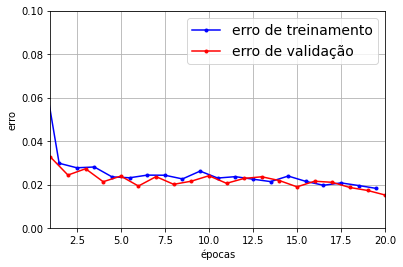

In [48]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [49]:
print('MSE:', model.evaluate(X_teste, Y_teste))

4/4 [==============================] - 0s 7ms/step - loss: 0.0152
MSE: 0.01517756562680006


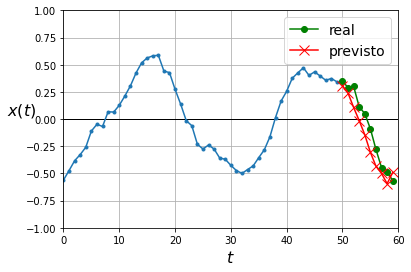

In [50]:
n_teste = 0
Y_pred = model.predict(X_teste)
plot_multiple_forecasts(X_teste[n_teste, :, 0], Y_teste[n_teste, :], Y_pred[n_teste, :])
plt.show()

## Previsão contínua de valores futuros

Em vez de treinar o modelo para prever os próximos 10 valores apenas na última etapa de tempo (como acabamos de fazer), podemos treiná-lo para **prever os próximos 10 valores em cada etapa de tempo**. Em outras palavras, podemos fazer que esta RNN produza uma sequência contínua de previsões.

No instante de tempo 0, o modelo produzirá um vetor contendo as previsões para os instantes de tempo 1 a 10. Em seguida, no instante 1, o modelo fará a previsão para os instantes 2 a 11, e assim por diante.

A vantagem é que, com mais saídas para construir uma sequẽncia de saída, haverá mais pesos internos e consequentemente melhores chances de ajustes durante o treinamento. Em geral isso vai acelerar e estabilizar o treinamento, eventualmente produzindo também previsões mais precisas.

Então, cada rótulo deve ser uma sequência do mesmo comprimento da sequência de entrada, contendo um vetor de 10 dimensões em cada etapa. O conjunto de treino precisa ser ajustado de acordo.

In [51]:
# inicialização de semente dos valores aleatórios
np.random.seed(42)

# geração de 1000 séries univariadas, cada uma com 50 medidas ao longo do tempo + 10 valores a ser previstos
n_steps = 50
series = generate_time_series(1000, n_steps + 10)

# criação dos conjuntos
X_treino = series[:700, :n_steps]
X_valid = series[700:900, :n_steps]
X_teste = series[900:, :n_steps]

# a diferença agora são os rótulos, que representam "janelas deslizantes" sobre os valores reais
Y = np.empty((1000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_treino = Y[:700]
Y_valid = Y[700:900]
Y_teste = Y[900:]

In [52]:
print('treino    atributos:', X_treino.shape)
print('treino    rótulos:  ', Y_treino.shape)
print('validação atributos:', X_valid.shape)
print('validação rótulos:  ', Y_valid.shape)
print('teste     atributos:', X_teste.shape)
print('teste     rótulos:  ', Y_teste.shape)

treino    atributos: (700, 50, 1)
treino    rótulos:   (700, 50, 10)
validação atributos: (200, 50, 1)
validação rótulos:   (200, 50, 10)
teste     atributos: (100, 50, 1)
teste     rótulos:   (100, 50, 10)


Para criar um modelo que produz uma sequência, devemos definir `return_sequences=True` em todas as camadas recorrentes (mesmo a última) e devemos aplicar a camada `Dense` de saída a cada passo de tempo.

Keras oferece uma camada do tipo `TimeDistributed` para este propósito: ela envolve qualquer camada (por exemplo, uma camada `Dense`) e a aplica a cada etapa de tempo de sua sequência de entrada.

A implementação faz isso de forma eficiente, remodelando as entradas para que cada etapa de tempo seja tratada como uma instância separada (ou seja, ele remodela as entradas de `[tamanho do lote, etapas de tempo, dimensões de entrada]` para `[tamanho do lote × etapas de tempo, dimensões de entrada]`. No nosso caso o número de dimensões de entrada é 20 porque a camada `SimpleRNN` tem 20 unidades. O Keras então executa a camada densa e, finalmente, remodela as saídas de volta para sequências (ou seja, ele remodela as saídas de `[tamanho do lote × etapas de tempo, dimensões de saída]` para `[tamanho do lote, etapas de tempo, dimensões de saída]`). Aqui o número de dimensões de saída é 10, já que a camada densa tem 10 neurônios.

In [53]:
# comando para 'zerar' a biblioteca Keras
keras.backend.clear_session()

# definição de sementes aleatórias
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
# modelo
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

Todas as saídas são necessárias durante o treinamento, mas apenas a saída da última etapa é útil para previsões e avaliação. Portanto, embora possamos contar com o MSE em todas as saídas para o treinamento, usaremos uma métrica personalizada para avaliação, dada pela função `last_mse`, para calcular apenas o MSE sobre a saída na última etapa de tempo.

In [55]:
# medida específica de desempenho
def last_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [56]:
# compilação
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=[last_mse])

# treinamento
%time history = model.fit(X_treino, Y_treino, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
22/22 [==============================] - 2s 33ms/step - loss: 0.0816 - last_mse: 0.0761 - val_loss: 0.0373 - val_last_mse: 0.0292
Epoch 2/20
22/22 [==============================] - 0s 20ms/step - loss: 0.0351 - last_mse: 0.0266 - val_loss: 0.0313 - val_last_mse: 0.0241
Epoch 3/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0329 - last_mse: 0.0242 - val_loss: 0.0306 - val_last_mse: 0.0230
Epoch 4/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0330 - last_mse: 0.0248 - val_loss: 0.0297 - val_last_mse: 0.0216
Epoch 5/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0318 - last_mse: 0.0236 - val_loss: 0.0300 - val_last_mse: 0.0233
Epoch 6/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0316 - last_mse: 0.0234 - val_loss: 0.0317 - val_last_mse: 0.0267
Epoch 7/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0309 - last_mse: 0.0232 - val_loss: 0.0288 - val_last_mse: 0.0217
Epoch 8/20
22

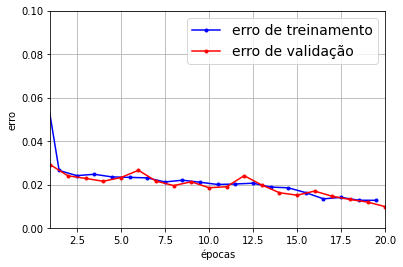

In [57]:
plot_learning_curves(history.history['last_mse'], history.history['val_last_mse'])
plt.show()

In [58]:
print('MSE:', model.evaluate(X_teste, Y_teste))

4/4 [==============================] - 0s 7ms/step - loss: 0.0212 - last_mse: 0.0096
MSE: [0.021209830418229103, 0.009588552638888359]


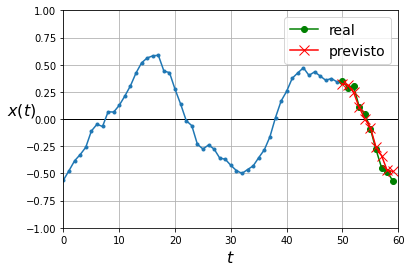

In [59]:
n_teste = 0
Y_pred = model.predict(X_teste)
plot_multiple_forecasts(X_teste[n_teste, :, 0], Y_teste[n_teste, -1, :], Y_pred[n_teste, -1, :])
plt.show()

## Camada LSTM

Modelos que transformam **sequências em sequências** podem ser otimizadas com camadas especializadas, que implementam **células de memória** capazes de lidar com longas sequências.

Um caso particular é a LSTM, que funciona como uma caixa-preta. Em relação a configurações mais profundas de camadas recorrentes, LSTMs são mais eficientes e têm melhor desempenho, além de detectar **dependências de longo prazo dentro de sequências**.

Usando Keras, você pode simplesmente usar a camada do tipo `LSTM` em vez de uma camada `SimpleRNN`. O código abaixo ilustra o mesmo processo de previsão contínua anterior, agora usando duas camadas LSTM.

In [60]:
# comando para 'zerar' a biblioteca Keras
keras.backend.clear_session()

# definição de sementes aleatórias
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
# modelo
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [62]:
# compilação
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=[last_mse])

# treinamento
%time history = model.fit(X_treino, Y_treino, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
22/22 [==============================] - 5s 74ms/step - loss: 0.0724 - last_mse: 0.0598 - val_loss: 0.0494 - val_last_mse: 0.0399
Epoch 2/20
22/22 [==============================] - 1s 39ms/step - loss: 0.0422 - last_mse: 0.0281 - val_loss: 0.0360 - val_last_mse: 0.0272
Epoch 3/20
22/22 [==============================] - 1s 39ms/step - loss: 0.0350 - last_mse: 0.0239 - val_loss: 0.0333 - val_last_mse: 0.0250
Epoch 4/20
22/22 [==============================] - 1s 38ms/step - loss: 0.0308 - last_mse: 0.0208 - val_loss: 0.0268 - val_last_mse: 0.0202
Epoch 5/20
22/22 [==============================] - 1s 39ms/step - loss: 0.0257 - last_mse: 0.0143 - val_loss: 0.0226 - val_last_mse: 0.0117
Epoch 6/20
22/22 [==============================] - 1s 39ms/step - loss: 0.0231 - last_mse: 0.0107 - val_loss: 0.0211 - val_last_mse: 0.0094
Epoch 7/20
22/22 [==============================] - 1s 39ms/step - loss: 0.0219 - last_mse: 0.0100 - val_loss: 0.0199 - val_last_mse: 0.0088
Epoch 8/20
22

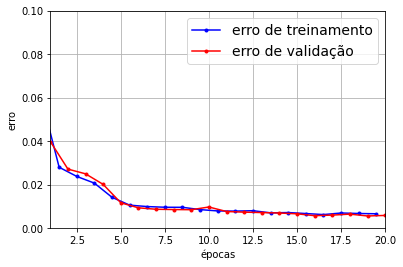

In [63]:
plot_learning_curves(history.history['last_mse'], history.history['val_last_mse'])
plt.show()

In [64]:
model.evaluate(X_teste, Y_teste)

4/4 [==============================] - 0s 10ms/step - loss: 0.0170 - last_mse: 0.0068


[0.016951818019151688, 0.006819217000156641]

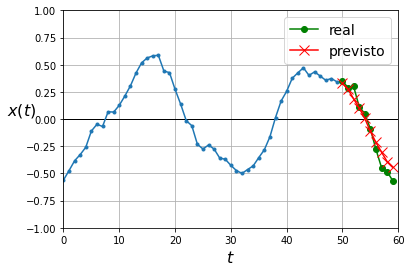

In [65]:
n_teste = 0
Y_pred = model.predict(X_teste)
plot_multiple_forecasts(X_teste[n_teste, :, 0], Y_teste[n_teste, -1, :], Y_pred[n_teste, -1, :])
plt.show()

## Camada GRU

Uma camada do tipo `GRU` implementa uma célula de memória semelhante à LSTM. Ainda que mais simples, seu desempenho e capacidade de aprendizado é semelhante à LSTM, e assim pode ser utilizado diretamente como substituição.

In [66]:
# comando para 'zerar' a biblioteca Keras
keras.backend.clear_session()

# definição de sementes aleatórias
np.random.seed(42)
tf.random.set_seed(42)

In [67]:
# modelo
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [68]:
# compilação
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=[last_mse])

# treinamento
%time history = model.fit(X_treino, Y_treino, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
22/22 [==============================] - 5s 76ms/step - loss: 0.0696 - last_mse: 0.0633 - val_loss: 0.0419 - val_last_mse: 0.0357
Epoch 2/20
22/22 [==============================] - 1s 42ms/step - loss: 0.0373 - last_mse: 0.0286 - val_loss: 0.0323 - val_last_mse: 0.0248
Epoch 3/20
22/22 [==============================] - 1s 42ms/step - loss: 0.0337 - last_mse: 0.0253 - val_loss: 0.0316 - val_last_mse: 0.0232
Epoch 4/20
22/22 [==============================] - 1s 43ms/step - loss: 0.0322 - last_mse: 0.0243 - val_loss: 0.0295 - val_last_mse: 0.0210
Epoch 5/20
22/22 [==============================] - 1s 42ms/step - loss: 0.0306 - last_mse: 0.0219 - val_loss: 0.0291 - val_last_mse: 0.0218
Epoch 6/20
22/22 [==============================] - 1s 44ms/step - loss: 0.0296 - last_mse: 0.0214 - val_loss: 0.0274 - val_last_mse: 0.0191
Epoch 7/20
22/22 [==============================] - 1s 43ms/step - loss: 0.0283 - last_mse: 0.0199 - val_loss: 0.0255 - val_last_mse: 0.0163
Epoch 8/20
22

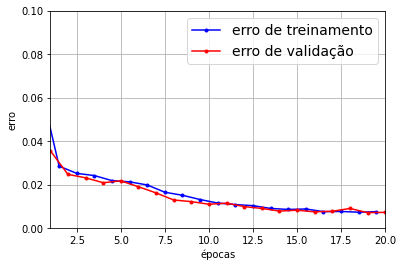

In [69]:
plot_learning_curves(history.history['last_mse'], history.history['val_last_mse'])
plt.show()

In [ ]:
model.evaluate(X_teste, Y_teste)

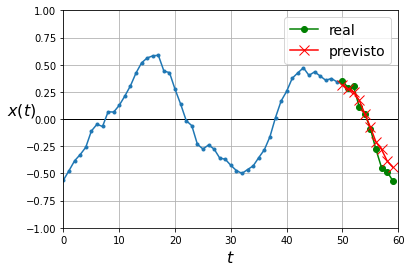

In [70]:
n_teste = 0
Y_pred = model.predict(X_teste)
plot_multiple_forecasts(X_teste[n_teste, :, 0], Y_teste[n_teste, -1, :], Y_pred[n_teste, -1, :])
plt.show()

# Processamento de Linguagem Natural

Uma das aplicações mais importantes de RNNs é processar linguagem humana, justamente tratando as sequências de entrada e saída como representações escritas (ou faladas).

Para serem competitivos, as arquiteturas de RNNs focadas em linguagem natural são bem mais complexas que os exemplos vistos até então. E, naturalmente, precisam ser treinadas com enormes conjuntos de textos, por exemplo.

Então vamos demonstrar duas aplicações usando modelos pré-treinados e bastante sofisticados.

## Medição de similaridade entre frases em diversas línguas

Vamos utilizar um modelo pré-treinado do Google chamado de `universal-sentence-encoder` [página oficial](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3).

Este é um exemplo de modelo que implementa **word embedding**, que recebe frases completas e as converte em representações numéricas. Essa representação pode então ser usada para medir a **similaridade semântica** entre frases. No caso específico desse modelo, está embutido o suporte para 16 idiomas diferentes.

Então é possível não apenas medir a similaridades entre frases de mesmo sentido em português, mas também compará-las com traduções em outras línguas.

Para isso precisamos primeiro instalar o pacote `tensorflow_text`, e depois acessar o modelo usando outro pacote (já disponível no Colaboratory) chamado de `tensorflow_hub`.

In [71]:
! pip install tensorflow_text

     |████████████████████████████████| 4.4 MB 30.7 MB/s 


In [72]:
import tensorflow_text
import tensorflow_hub as hub

In [73]:
# download do modelo
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')

In [74]:
# frases semelhantes
e1 = embed(['Eu gosto de sorvete.'])
e2 = embed(['Eu acho sorvete uma delícia.', 'Sorvete é bom.', 'Sorvete é muito bom.', 'Sorvete não é bom.'])

In [75]:
# matrix de similaridade
print(np.inner(e1, e2))

[[0.87822694 0.66143066 0.6521292  0.5769995 ]]


In [76]:
# traduções
e_inglês = embed(['dog', 'Puppies are nice.', 'I enjoy taking long walks along the beach with my dog.'])
e_português = embed(['cão', 'Cachorrinhos são legais.', 'Eu gosto de fazer longas caminhadas na praia com o meu cão.'])

In [77]:
# matrix de similaridade
print(np.inner(e_inglês, e_português))

[[0.94220155 0.27447775 0.28095925]
 [0.40962547 0.60502017 0.26476216]
 [0.2334198  0.20695932 0.8429813 ]]


## Completar frases

O exemplo abaixo usa o pacote `transformers` e um modelo pré-treinado para a Língua Portuguesa chamado [BERTimbau](https://huggingface.co/neuralmind/bert-base-portuguese-cased) para completar palavras faltantes em frases.

Este é um exemplo de uso da nova arquitetura de redes neurais chamada de [Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)), que generaliza os modelos sequenciais de RNN com o conceito de **mecanismos de atenção**.

In [78]:
! pip install transformers

     |████████████████████████████████| 2.9 MB 39.4 MB/s 
     |████████████████████████████████| 895 kB 35.1 MB/s 
     |████████████████████████████████| 3.3 MB 28.9 MB/s 
     |████████████████████████████████| 636 kB 43.6 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [79]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer

In [80]:
model = AutoModelForMaskedLM.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased') #, do_lower_case=False)

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [81]:
from transformers import pipeline

completar = pipeline('fill-mask', model=model, tokenizer=tokenizer)

In [82]:
completar('Tinha uma [MASK] no meio do caminho.', top_k=2)

[{'score': 0.14287810027599335,
  'sequence': 'Tinha uma pedra no meio do caminho.',
  'token': 5028,
  'token_str': 'pedra'},
 {'score': 0.06213385984301567,
  'sequence': 'Tinha uma árvore no meio do caminho.',
  'token': 7411,
  'token_str': 'árvore'}]

In [83]:
completar('Colocar [MASK] no café.', top_k=5)

[{'score': 0.22539633512496948,
  'sequence': 'Colocar água no café.',
  'token': 1991,
  'token_str': 'água'},
 {'score': 0.2130902260541916,
  'sequence': 'Colocar açúcar no café.',
  'token': 11755,
  'token_str': 'açúcar'},
 {'score': 0.15163828432559967,
  'sequence': 'Colocar sal no café.',
  'token': 1390,
  'token_str': 'sal'},
 {'score': 0.08424992114305496,
  'sequence': 'Colocar gelo no café.',
  'token': 8096,
  'token_str': 'gelo'},
 {'score': 0.03817732632160187,
  'sequence': 'Colocar tudo no café.',
  'token': 2745,
  'token_str': 'tudo'}]

## Geração de texto

Para finalizar, usando o mesmo modelo e mecanismo de codificação/decodificação de frases, vamos extrapolar as palavras de uma frase, assim como diversos valores futuros poderiam ser previstos em uma série temporal.

In [84]:
from textwrap import wrap

In [85]:
# codifica uma frase de Machado de Assis (Memórias Póstumas de Brás Cubas)
entrada = tokenizer.encode('Não te irrites se te pagarem mal um benefício: antes cair das nuvens, que de um terceiro andar',
                           add_special_tokens=False,
                           return_tensors='pt')

In [86]:
# gera texto com o tamanho especificado
saída = model.generate(entrada, 
                       max_length=50,
                       num_beams=5,
                       no_repeat_ngram_size=2,
                       early_stopping=True)

In [87]:
# decodifica a saída
texto = tokenizer.decode(saída[0], skip_special_tokens=True)
for linha in wrap(texto):
    print(linha)

Não te irrites se te pagarem mal um benefício : antes cair das nuvens,
que de um terceiro andar do prédio, ou melhor, antes de ir embora do
trabalho do chefe, e ainda mais, depois disso, porque, se tu pagar mal
